Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1FllL2kWZ5q1E0alqyLz7TGC1qlKYwJxN'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1pJS8Cc_AeixyHXgXm9uB_KaboX5E-G40'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1IYIIMhI1uQNjxlp9D4WzEBKLk20gE6RC'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1817
Number of dev sentences:  321
Number of test sentences:  378
Number of words in the training dataset:  11597
Number of words in the dev dataset:  4202
Number of words in the test dataset:  5076
Tags in the training dataset: ['I-LEGISLACAO', 'B-LEGISLACAO', 'O']
Number of Labels in the training dataset:  3
Tags in the dev dataset: ['I-LEGISLACAO', 'B-LEGISLACAO', 'O']
Number of Labels in the dev dataset:  3
Tags in the test dataset: ['I-LEGISLACAO', 'B-LEGISLACAO', 'O']
Number of Labels in the test dataset:  3
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 671,“,O
1,Sentence: 671,Agravo,O
2,Sentence: 671,regimental,O
3,Sentence: 671,em,O
4,Sentence: 671,habeas,O
5,Sentence: 671,corpus,O
6,Sentence: 671,.,O
7,Sentence: 671,Homicídio,O
8,Sentence: 671,qualificado,O
9,Sentence: 671,(,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('em', 'O'),
 ('seus', 'O'),
 ('votos', 'O'),
 ('os', 'O'),
 ('argumentos', 'O'),
 ('de', 'O'),
 ('ambas', 'O'),
 ('as', 'O'),
 ('partes', 'O'),
 (',', 'O'),
 ('não', 'O'),
 ('havendo', 'O'),
 ('reconhecer', 'O'),
 (',', 'O'),
 ('agora', 'O'),
 (',', 'O'),
 ('quaisquer', 'O'),
 ('dos', 'O'),
 ('vícios', 'O'),
 ('do', 'O'),
 ('art.', 'B-LEGISLACAO'),
 ('1.022', 'I-LEGISLACAO'),
 (',', 'O'),
 ('do', 'O'),
 ('Código', 'B-LEGISLACAO'),
 ('de', 'I-LEGISLACAO'),
 ('Processo', 'I-LEGISLACAO'),
 ('Civil', 'I-LEGISLACAO'),
 ('.', 'O')]

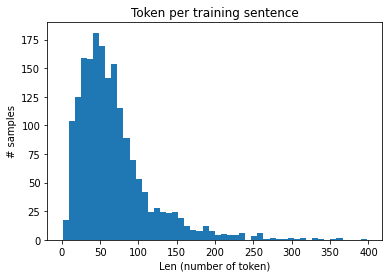

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

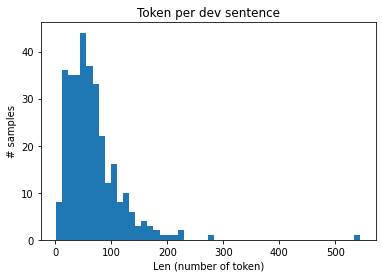

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

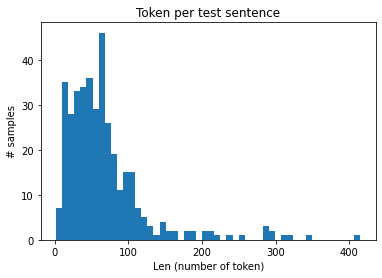

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'civil'
print(word2idx['civil'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-LEGISLACAO'
print(tag2idx['B-LEGISLACAO'])
# Tag of index 0
print(idx2tag[0])

4197
Consta
1
I-LEGISLACAO


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9724)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1817
Points in y_train before removal: 1817
Points in X_train before removal: 1817
Points in y_train before removal: 1817


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[1064, 12743, 11813, 8981, 11009, 1987, 157, 9382, 7251, 12743, 2724, 8981, 2891, 13404, 2177, 8734, 3701, 2654, 2294, 2786, 2423, 13441, 2129, 8981, 11899, 3329, 13441, 9883, 5326, 12463, 8981, 12743, 12413, 8981, 4987, 12323, 13402, 8637, 2654, 8981, 11295, 1016, 13441, 8946, 8637, 10774, 9197, 8637, 6167, 8981, 239, 9577, 3946, 2294, 2561, 8637, 4021, 8713, 477, 1226, 2294, 3161, 13441, 4714, 3628]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[4844, 12382, 8981, 10979, 2654, 7340, 5349, 11009, 570, 8637, 5452, 7956, 3989, 732, 10638, 8637, 9954, 8637, 12501, 3110, 8981, 7769, 7308, 8478, 11802, 2324, 12323, 6987, 3962, 8637, 11091, 12710, 7762, 13000, 3218, 6149, 10416, 9397, 8637, 176, 8290, 12323, 10484, 8981, 12323, 5375, 8981, 5820, 3701, 12323, 13343, 373, 11899, 7543, 8713, 3663, 10338, 11719, 12496, 2603, 8981, 10515, 8981, 871

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 44.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 30.3 MB/s 
     |████████████████████████████████| 7.6 MB 82.1 MB/s 
     |████████████████████████████████| 163 kB 69.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.4 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=4e1c2b437f497da137712b26e640d234a1abae4044713d0a5df43d63b3881bce
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[13250, 9970, 6531, 5394, 11557, 12031, 3539, 5954, 4022, 

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

from transformers import pipeline
from future.utils import iteritems

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [4]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [5]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [6]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [7]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word = generate_sentences(X_train, y_train, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[updated_idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[updated_idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[updated_idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [8]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9228132963180542
Training loss epoch: 0.39307268602507456
Training accuracy epoch: 0.8799802252411988
Validating model...
Validation Loss: 0.23399650624820165
Validation Accuracy: 0.927875258790644
Training epoch: 2
Training loss per 100 training steps: 0.21065792441368103
Training loss epoch: 0.19229275626795633
Training accuracy epoch: 0.9307203565688942
Validating model...
Validation Loss: 0.13381615937465713
Validation Accuracy: 0.9583918421416128
Training epoch: 3
Training loss per 100 training steps: 0.11024822294712067
Training loss epoch: 0.08620341068931989
Training accuracy epoch: 0.9768664867800048
Validating model...
Validation Loss: 0.09079218389732498
Validation Accuracy: 0.9734198176704024
Training epoch: 4
Training loss per 100 training steps: 0.03260980546474457
Training loss epoch: 0.03931048033492906
Training accuracy epoch: 0.9887389959017903
Validating model...
Validation Loss: 0.08549500434171586
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05769782579348733
Validation Accuracy: 0.9845960955809495
Validation duration: 0.22463929999999976 minutes
F1-score (test): 86.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.88      0.86      1238

   micro avg       0.84      0.88      0.86      1238
   macro avg       0.84      0.88      0.86      1238
weighted avg       0.84      0.88      0.86      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2555583715438843
Training loss epoch: 0.46986663341522217
Training accuracy epoch: 0.8139170653453818
Validating model...
Validation Loss: 0.26329995478902546
Validation Accuracy: 0.910524156324201
Training epoch: 2
Training loss per 100 training steps: 0.19190621376037598
Training loss epoch: 0.19967722467013768
Training accuracy epoch: 0.9347292687520949
Validating model...
Validation Loss: 0.13651392129915102
Validation Accuracy: 0.9649622427708202
Training epoch: 3
Training loss per 100 training steps: 0.1897062212228775
Training loss epoch: 0.09668053047997612
Training accuracy epoch: 0.9739642694969346
Validating model...
Validation Loss: 0.09605910327462923
Validation Accuracy: 0.9735866246971889
Training epoch: 4
Training loss per 100 training steps: 0.05411694943904877
Training loss epoch: 0.06456523495061058
Training accuracy epoch: 0.9818009725106671
Validating model...
Validation Loss: 0.08923043647692316
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06233974227992197
Validation Accuracy: 0.9808226906505473
Validation duration: 0.23400699999999972 minutes
F1-score (test): 81.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.81      0.82      0.82      1238

   micro avg       0.81      0.82      0.82      1238
   macro avg       0.81      0.82      0.82      1238
weighted avg       0.81      0.82      0.82      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2565512657165527
Training loss epoch: 0.4987272449902126
Training accuracy epoch: 0.7927202750782729
Validating model...
Validation Loss: 0.2684699602070309
Validation Accuracy: 0.9008081521892665
Training epoch: 2
Training loss per 100 training steps: 0.2282264232635498
Training loss epoch: 0.17722738747085845
Training accuracy epoch: 0.9375265382612455
Validating model...
Validation Loss: 0.13628638074511573
Validation Accuracy: 0.9486544785185389
Training epoch: 3
Training loss per 100 training steps: 0.11911649256944656
Training loss epoch: 0.0877498100910868
Training accuracy epoch: 0.969784828869335
Validating model...
Validation Loss: 0.10364027339078132
Validation Accuracy: 0.9679045270689247
Training epoch: 4
Training loss per 100 training steps: 0.03877473995089531
Training loss epoch: 0.05180915551526206
Training accuracy epoch: 0.9879936267937762
Validating model...
Validation Loss: 0.08154816198207084
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05804857867769897
Validation Accuracy: 0.9859140880944267
Validation duration: 0.2341277666666675 minutes
F1-score (test): 88.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.91      0.89      1238

   micro avg       0.86      0.91      0.89      1238
   macro avg       0.86      0.91      0.89      1238
weighted avg       0.86      0.91      0.89      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0218209028244019
Training loss epoch: 0.4104666369301932
Training accuracy epoch: 0.863540060583988
Validating model...
Validation Loss: 0.25634091311977025
Validation Accuracy: 0.9246295013952717
Training epoch: 2
Training loss per 100 training steps: 0.2646888792514801
Training loss epoch: 0.18205573090485164
Training accuracy epoch: 0.936454545121751
Validating model...
Validation Loss: 0.12114112469412032
Validation Accuracy: 0.9657277435996539
Training epoch: 3
Training loss per 100 training steps: 0.07940041273832321
Training loss epoch: 0.0762772655912808
Training accuracy epoch: 0.9818797654223699
Validating model...
Validation Loss: 0.21311203177486146
Validation Accuracy: 0.9253999520656014
Training epoch: 4
Training loss per 100 training steps: 0.020521096885204315
Training loss epoch: 0.040853052000914304
Training accuracy epoch: 0.9889914317907185
Validating model...
Validation Loss: 0.09052562267918672
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06398908592139681
Validation Accuracy: 0.984805051418062
Validation duration: 0.23178876666666687 minutes
F1-score (test): 89.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.91      0.89      1238

   micro avg       0.87      0.91      0.89      1238
   macro avg       0.87      0.91      0.89      1238
weighted avg       0.87      0.91      0.89      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2161670923233032
Training loss epoch: 0.4997105066265379
Training accuracy epoch: 0.8148126073094794
Validating model...
Validation Loss: 0.3432308825708571
Validation Accuracy: 0.8987341046929536
Training epoch: 2
Training loss per 100 training steps: 0.25782477855682373
Training loss epoch: 0.2471496037074498
Training accuracy epoch: 0.9120912157114492
Validating model...
Validation Loss: 0.16890950288091386
Validation Accuracy: 0.9479928620702313
Training epoch: 3
Training loss per 100 training steps: 0.19114480912685394
Training loss epoch: 0.1161088975412505
Training accuracy epoch: 0.9640180340984771
Validating model...
Validation Loss: 0.11425208477746873
Validation Accuracy: 0.9650972920166713
Training epoch: 4
Training loss per 100 training steps: 0.0798037052154541
Training loss epoch: 0.0582588974918638
Training accuracy epoch: 0.9813040864520712
Validating model...
Validation Loss: 0.0952351556292602
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.057043800848380975
Validation Accuracy: 0.9857850078774889
Validation duration: 0.23298798333333176 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.87      0.87      1238

   micro avg       0.87      0.87      0.87      1238
   macro avg       0.87      0.87      0.87      1238
weighted avg       0.87      0.87      0.87      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1723730564117432
Training loss epoch: 0.47090775626046316
Training accuracy epoch: 0.8059273010089504
Validating model...
Validation Loss: 0.2821105881815865
Validation Accuracy: 0.9000096339123147
Training epoch: 2
Training loss per 100 training steps: 0.3294604420661926
Training loss epoch: 0.18764762048210418
Training accuracy epoch: 0.935404290946843
Validating model...
Validation Loss: 0.14227382891944476
Validation Accuracy: 0.9556855984844468
Training epoch: 3
Training loss per 100 training steps: 0.13452331721782684
Training loss epoch: 0.09494414872356824
Training accuracy epoch: 0.9680630234136707
Validating model...
Validation Loss: 0.09021096392756417
Validation Accuracy: 0.9710650397143569
Training epoch: 4
Training loss per 100 training steps: 0.047153323888778687
Training loss epoch: 0.051150183592523844
Training accuracy epoch: 0.9824258569485967
Validating model...
Validation Loss: 0.0760034649366779
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07506256395330031
Validation Accuracy: 0.979756590326896
Validation duration: 0.23088116666666564 minutes
F1-score (test): 82.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.83      0.82      0.82      1238

   micro avg       0.83      0.82      0.82      1238
   macro avg       0.83      0.82      0.82      1238
weighted avg       0.83      0.82      0.82      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1581696271896362
Training loss epoch: 0.46127037916864666
Training accuracy epoch: 0.8058180143991309
Validating model...
Validation Loss: 0.2518778681045487
Validation Accuracy: 0.9018245971107668
Training epoch: 2
Training loss per 100 training steps: 0.1902436465024948
Training loss epoch: 0.18337186106613704
Training accuracy epoch: 0.9327825262793407
Validating model...
Validation Loss: 0.13530786255640642
Validation Accuracy: 0.9622485758516015
Training epoch: 3
Training loss per 100 training steps: 0.0964401438832283
Training loss epoch: 0.08644775886620794
Training accuracy epoch: 0.9752334587131603
Validating model...
Validation Loss: 0.10241216509824708
Validation Accuracy: 0.9652116072349227
Training epoch: 4
Training loss per 100 training steps: 0.02643715962767601
Training loss epoch: 0.040292183070310524
Training accuracy epoch: 0.9882625783181537
Validating model...
Validation Loss: 0.09468944870778137
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07183459591275702
Validation Accuracy: 0.9817966933477059
Validation duration: 0.23392320000000003 minutes
F1-score (test): 84.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.82      0.85      1238

   micro avg       0.87      0.82      0.85      1238
   macro avg       0.87      0.82      0.85      1238
weighted avg       0.87      0.82      0.85      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0875829458236694
Training loss epoch: 0.45050108432769775
Training accuracy epoch: 0.8262346809532846
Validating model...
Validation Loss: 0.2730750356401716
Validation Accuracy: 0.8998703434530164
Training epoch: 2
Training loss per 100 training steps: 0.23935960233211517
Training loss epoch: 0.17843412182160787
Training accuracy epoch: 0.9403691237701058
Validating model...
Validation Loss: 0.13162593366134734
Validation Accuracy: 0.9550127715616143
Training epoch: 3
Training loss per 100 training steps: 0.08539953827857971
Training loss epoch: 0.08308212671961103
Training accuracy epoch: 0.9766824088519291
Validating model...
Validation Loss: 0.09135237748601607
Validation Accuracy: 0.9730529755011559
Training epoch: 4
Training loss per 100 training steps: 0.04190458357334137
Training loss epoch: 0.032985352511916845
Training accuracy epoch: 0.9924730582809722
Validating model...
Validation Loss: 0.10081940942576953
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07366252643987536
Validation Accuracy: 0.9817168123067735
Validation duration: 0.23082094999999753 minutes
F1-score (test): 84.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.85      0.84      1238

   micro avg       0.84      0.85      0.84      1238
   macro avg       0.84      0.85      0.84      1238
weighted avg       0.84      0.85      0.84      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.113923192024231
Training loss epoch: 0.504401194197791
Training accuracy epoch: 0.8183995025270109
Validating model...
Validation Loss: 0.28552683833099546
Validation Accuracy: 0.9009723188744717
Training epoch: 2
Training loss per 100 training steps: 0.2113751620054245
Training loss epoch: 0.17480128471340453
Training accuracy epoch: 0.9433406163896729
Validating model...
Validation Loss: 0.1828767526007834
Validation Accuracy: 0.93056389942507
Training epoch: 3
Training loss per 100 training steps: 0.12362603098154068
Training loss epoch: 0.11787199175783566
Training accuracy epoch: 0.9593791761947598
Validating model...
Validation Loss: 0.1070817435781161
Validation Accuracy: 0.9651334704303174
Training epoch: 4
Training loss per 100 training steps: 0.07284107059240341
Training loss epoch: 0.05822522246411869
Training accuracy epoch: 0.9816335935381847
Validating model...
Validation Loss: 0.09485795304533981
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06162796153997382
Validation Accuracy: 0.9848139709985229
Validation duration: 0.23198138333333038 minutes
F1-score (test): 87.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.91      0.87      1238

   micro avg       0.84      0.91      0.87      1238
   macro avg       0.84      0.91      0.87      1238
weighted avg       0.84      0.91      0.87      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2499794960021973
Training loss epoch: 0.5094137915543148
Training accuracy epoch: 0.7905561574777351
Validating model...
Validation Loss: 0.30208126916771844
Validation Accuracy: 0.8941309274128615
Training epoch: 2
Training loss per 100 training steps: 0.2746255695819855
Training loss epoch: 0.2255392340677125
Training accuracy epoch: 0.9173103419169927
Validating model...
Validation Loss: 0.1681028771258536
Validation Accuracy: 0.9470400443098453
Training epoch: 3
Training loss per 100 training steps: 0.10993672162294388
Training loss epoch: 0.10305650638682502
Training accuracy epoch: 0.9674710085557383
Validating model...
Validation Loss: 0.09934927973275383
Validation Accuracy: 0.9702208127611788
Training epoch: 4
Training loss per 100 training steps: 0.08156093209981918
Training loss epoch: 0.04346551559865475
Training accuracy epoch: 0.9882674027890624
Validating model...
Validation Loss: 0.08431756354513623
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.060612053726799786
Validation Accuracy: 0.985696314885053
Validation duration: 0.2356918999999986 minutes
F1-score (test): 88.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.91      0.88      1238

   micro avg       0.86      0.91      0.88      1238
   macro avg       0.86      0.91      0.88      1238
weighted avg       0.86      0.91      0.88      1238



In [9]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9367596507072449
Training loss epoch: 0.39322921447455883
Training accuracy epoch: 0.8720679546495674
Validating model...
Validation Loss: 0.21633741614364443
Validation Accuracy: 0.9122119662111442
Training epoch: 2
Training loss per 100 training steps: 0.23276489973068237
Training loss epoch: 0.142728460021317
Training accuracy epoch: 0.9494394667100805
Validating model...
Validation Loss: 0.13182345990623748
Validation Accuracy: 0.9558753702727788
Training epoch: 3
Training loss per 100 training steps: 0.07500653713941574
Training loss epoch: 0.06449970742687583
Training accuracy epoch: 0.9793534517647277
Validating model...
Validation Loss: 0.15481386014393397
Validation Accuracy: 0.9523044787859537
Training epoch: 4
Training loss per 100 training steps: 0.06700059026479721
Training loss epoch: 0.03573628456797451
Training accuracy epoch: 0.9911956357317291
Validating model...
Validation Loss: 0.09424916672564689
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05440728242198626
Validation Accuracy: 0.9867347733901681
Validation duration: 0.23200786666667075 minutes
F1-score (test): 89.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.90      0.89      1238

   micro avg       0.88      0.90      0.89      1238
   macro avg       0.88      0.90      0.89      1238
weighted avg       0.88      0.90      0.89      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2670629024505615
Training loss epoch: 0.4874514043331146
Training accuracy epoch: 0.8092290144279464
Validating model...
Validation Loss: 0.29158700151102884
Validation Accuracy: 0.8999335185873976
Training epoch: 2
Training loss per 100 training steps: 0.3051292598247528
Training loss epoch: 0.20724046602845192
Training accuracy epoch: 0.9232976849553375
Validating model...
Validation Loss: 0.1993411456545194
Validation Accuracy: 0.9231791867023315
Training epoch: 3
Training loss per 100 training steps: 0.13835516571998596
Training loss epoch: 0.10115405381657183
Training accuracy epoch: 0.9682223164187431
Validating model...
Validation Loss: 0.08857169161949839
Validation Accuracy: 0.9731810713183012
Training epoch: 4
Training loss per 100 training steps: 0.039358947426080704
Training loss epoch: 0.04177902406081557
Training accuracy epoch: 0.9880236890719566
Validating model...
Validation Loss: 0.08217108196445874
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05670303533164164
Validation Accuracy: 0.9842211919020695
Validation duration: 0.23229893333333773 minutes
F1-score (test): 87.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.89      0.87      1238

   micro avg       0.85      0.89      0.87      1238
   macro avg       0.85      0.89      0.87      1238
weighted avg       0.85      0.89      0.87      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3221408128738403
Training loss epoch: 0.4853569008409977
Training accuracy epoch: 0.8035791277068488
Validating model...
Validation Loss: 0.2162829176301048
Validation Accuracy: 0.9124663960456196
Training epoch: 2
Training loss per 100 training steps: 0.19190570712089539
Training loss epoch: 0.162547561340034
Training accuracy epoch: 0.9454967354202604
Validating model...
Validation Loss: 0.1395058064233689
Validation Accuracy: 0.953904895169062
Training epoch: 3
Training loss per 100 training steps: 0.08423984050750732
Training loss epoch: 0.06735001038759947
Training accuracy epoch: 0.9786110346205544
Validating model...
Validation Loss: 0.09450731728048552
Validation Accuracy: 0.9731338132572831
Training epoch: 4
Training loss per 100 training steps: 0.06914535164833069
Training loss epoch: 0.032025643973611295
Training accuracy epoch: 0.9933057285743011
Validating model...
Validation Loss: 0.08149079570458048
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0675509653519839
Validation Accuracy: 0.9838431786823535
Validation duration: 0.23460931666666815 minutes
F1-score (test): 86.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.88      0.86      1238

   micro avg       0.85      0.88      0.86      1238
   macro avg       0.85      0.88      0.86      1238
weighted avg       0.85      0.88      0.86      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2357620000839233
Training loss epoch: 0.48335125669837
Training accuracy epoch: 0.8082438042309706
Validating model...
Validation Loss: 0.2578290012620744
Validation Accuracy: 0.9172717332001074
Training epoch: 2
Training loss per 100 training steps: 0.24476872384548187
Training loss epoch: 0.19569339789450169
Training accuracy epoch: 0.9387285093687687
Validating model...
Validation Loss: 0.12107532187586739
Validation Accuracy: 0.9622034673916209
Training epoch: 3
Training loss per 100 training steps: 0.12948890030384064
Training loss epoch: 0.0721731181256473
Training accuracy epoch: 0.9807409380401897
Validating model...
Validation Loss: 0.09425306568543117
Validation Accuracy: 0.9714571046346495
Training epoch: 4
Training loss per 100 training steps: 0.06148320809006691
Training loss epoch: 0.03036967059597373
Training accuracy epoch: 0.9916008100444889
Validating model...
Validation Loss: 0.09218685719228926
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05985145406642308
Validation Accuracy: 0.9847813308594978
Validation duration: 0.23129749999999755 minutes
F1-score (test): 89.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.94      0.89      1238

   micro avg       0.85      0.94      0.89      1238
   macro avg       0.85      0.94      0.89      1238
weighted avg       0.85      0.94      0.89      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.221254587173462
Training loss epoch: 0.48550397902727127
Training accuracy epoch: 0.8202062225320075
Validating model...
Validation Loss: 0.26095683375994366
Validation Accuracy: 0.9038200087555546
Training epoch: 2
Training loss per 100 training steps: 0.24490325152873993
Training loss epoch: 0.20078733004629612
Training accuracy epoch: 0.9298795122987423
Validating model...
Validation Loss: 0.15564255913098654
Validation Accuracy: 0.9513907752478782
Training epoch: 3
Training loss per 100 training steps: 0.1627359390258789
Training loss epoch: 0.09805848030373454
Training accuracy epoch: 0.9724200435683392
Validating model...
Validation Loss: 0.10634349069247644
Validation Accuracy: 0.9657620681831189
Training epoch: 4
Training loss per 100 training steps: 0.045793987810611725
Training loss epoch: 0.04370526620186865
Training accuracy epoch: 0.9888610507185529
Validating model...
Validation Loss: 0.08356235850424994
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06374006958988805
Validation Accuracy: 0.9848782050742085
Validation duration: 0.2329397333333342 minutes
F1-score (test): 88.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.89      0.88      1238

   micro avg       0.87      0.89      0.88      1238
   macro avg       0.87      0.89      0.88      1238
weighted avg       0.87      0.89      0.88      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.194247841835022
Training loss epoch: 0.4645920880138874
Training accuracy epoch: 0.8185140903706296
Validating model...
Validation Loss: 0.27663673886231016
Validation Accuracy: 0.9015538453866576
Training epoch: 2
Training loss per 100 training steps: 0.26833054423332214
Training loss epoch: 0.19652686547487974
Training accuracy epoch: 0.9290212757292985
Validating model...
Validation Loss: 0.14805679857021287
Validation Accuracy: 0.9552907455107826
Training epoch: 3
Training loss per 100 training steps: 0.11389686167240143
Training loss epoch: 0.07838264759629965
Training accuracy epoch: 0.9775625706772513
Validating model...
Validation Loss: 0.09806387836024874
Validation Accuracy: 0.9707461072482815
Training epoch: 4
Training loss per 100 training steps: 0.06767009198665619
Training loss epoch: 0.0333616059506312
Training accuracy epoch: 0.9906203556152505
Validating model...
Validation Loss: 0.08046400955035574
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0632562164682895
Validation Accuracy: 0.9850773376605279
Validation duration: 0.2359028166666576 minutes
F1-score (test): 88.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.90      0.88      1238

   micro avg       0.86      0.90      0.88      1238
   macro avg       0.86      0.90      0.88      1238
weighted avg       0.86      0.90      0.88      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1867806911468506
Training loss epoch: 0.46659304574131966
Training accuracy epoch: 0.825459779604234
Validating model...
Validation Loss: 0.27027666639714015
Validation Accuracy: 0.9008775306960566
Training epoch: 2
Training loss per 100 training steps: 0.23238296806812286
Training loss epoch: 0.20676257275044918
Training accuracy epoch: 0.924271238533375
Validating model...
Validation Loss: 0.16497030712309338
Validation Accuracy: 0.9464793889740685
Training epoch: 3
Training loss per 100 training steps: 0.11056695878505707
Training loss epoch: 0.10066512878984213
Training accuracy epoch: 0.971192188607373
Validating model...
Validation Loss: 0.10643188655376434
Validation Accuracy: 0.9682059919579311
Training epoch: 4
Training loss per 100 training steps: 0.08774564415216446
Training loss epoch: 0.04172970535000786
Training accuracy epoch: 0.9900406428124591
Validating model...
Validation Loss: 0.08320173688255073
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06027429609093815
Validation Accuracy: 0.9862962817851914
Validation duration: 0.23217296666666698 minutes
F1-score (test): 89.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.89      0.89      1238

   micro avg       0.90      0.89      0.89      1238
   macro avg       0.90      0.89      0.89      1238
weighted avg       0.90      0.89      0.89      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1167210340499878
Training loss epoch: 0.44932952150702477
Training accuracy epoch: 0.8394222622173315
Validating model...
Validation Loss: 0.31066083695207325
Validation Accuracy: 0.8959223298220877
Training epoch: 2
Training loss per 100 training steps: 0.26895269751548767
Training loss epoch: 0.21177588775753975
Training accuracy epoch: 0.9197072663205665
Validating model...
Validation Loss: 0.1936338660972459
Validation Accuracy: 0.9140944558134156
Training epoch: 3
Training loss per 100 training steps: 0.1177956685423851
Training loss epoch: 0.11097340006381273
Training accuracy epoch: 0.9619689903430508
Validating model...
Validation Loss: 0.10156106487626121
Validation Accuracy: 0.9658763110006157
Training epoch: 4
Training loss per 100 training steps: 0.06715498864650726
Training loss epoch: 0.045704750111326575
Training accuracy epoch: 0.9875249191881253
Validating model...
Validation Loss: 0.10612211021639052
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06441793761526544
Validation Accuracy: 0.9843104199675632
Validation duration: 0.23396571666667115 minutes
F1-score (test): 87.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.88      0.87      1238

   micro avg       0.87      0.88      0.87      1238
   macro avg       0.87      0.88      0.87      1238
weighted avg       0.87      0.88      0.87      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9891711473464966
Training loss epoch: 0.46433253586292267
Training accuracy epoch: 0.8576225674634402
Validating model...
Validation Loss: 0.3160761438664936
Validation Accuracy: 0.8998142685670834
Training epoch: 2
Training loss per 100 training steps: 0.2867780029773712
Training loss epoch: 0.24169731698930264
Training accuracy epoch: 0.9231074471898837
Validating model...
Validation Loss: 0.17217099489200682
Validation Accuracy: 0.9450376015799582
Training epoch: 3
Training loss per 100 training steps: 0.14525215327739716
Training loss epoch: 0.1153538404032588
Training accuracy epoch: 0.9658724909635215
Validating model...
Validation Loss: 0.10079170550618853
Validation Accuracy: 0.9672778377255158
Training epoch: 4
Training loss per 100 training steps: 0.07093766331672668
Training loss epoch: 0.04393242672085762
Training accuracy epoch: 0.9881385175449708
Validating model...
Validation Loss: 0.0729819189845806
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07124977186322212
Validation Accuracy: 0.9826916043940397
Validation duration: 0.23167283333332306 minutes
F1-score (test): 87.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.90      0.87      1238

   micro avg       0.85      0.90      0.87      1238
   macro avg       0.85      0.90      0.87      1238
weighted avg       0.85      0.90      0.87      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1232963800430298
Training loss epoch: 0.428435031324625
Training accuracy epoch: 0.8312930528932123
Validating model...
Validation Loss: 0.23969154627550215
Validation Accuracy: 0.9230360665977043
Training epoch: 2
Training loss per 100 training steps: 0.21996045112609863
Training loss epoch: 0.19388093519955873
Training accuracy epoch: 0.9336293453404784
Validating model...
Validation Loss: 0.15097276405209586
Validation Accuracy: 0.9565816553315507
Training epoch: 3
Training loss per 100 training steps: 0.12692387402057648
Training loss epoch: 0.095114566385746
Training accuracy epoch: 0.9741496380271717
Validating model...
Validation Loss: 0.10031745245768911
Validation Accuracy: 0.9682023293901677
Training epoch: 4
Training loss per 100 training steps: 0.0659274086356163
Training loss epoch: 0.04472456010989845
Training accuracy epoch: 0.987208744441025
Validating model...
Validation Loss: 0.07919024126160712
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0680436912807636
Validation Accuracy: 0.9861468437174379
Validation duration: 0.23139556666666675 minutes
F1-score (test): 88.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.90      0.89      1238

   micro avg       0.87      0.90      0.89      1238
   macro avg       0.87      0.90      0.89      1238
weighted avg       0.87      0.90      0.89      1238



In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2014107704162598
Training loss epoch: 0.46029356122016907
Training accuracy epoch: 0.8223728039091938
Validating model...
Validation Loss: 0.2158964297601155
Validation Accuracy: 0.9303092684261874
Training epoch: 2
Training loss per 100 training steps: 0.23679763078689575
Training loss epoch: 0.14074190706014633
Training accuracy epoch: 0.955242184911039
Validating model...
Validation Loss: 0.11327058502605983
Validation Accuracy: 0.9671893091980701
Training epoch: 3
Training loss per 100 training steps: 0.06224904581904411
Training loss epoch: 0.05263704827262296
Training accuracy epoch: 0.9842594095305272
Validating model...
Validation Loss: 0.10759214968198821
Validation Accuracy: 0.9717026140724849
Training epoch: 4
Training loss per 100 training steps: 0.06381852179765701
Training loss epoch: 0.01914705036001073
Training accuracy epoch: 0.9947850140428982
Validating model...
Validation Loss: 0.08478062848250072
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06823983272382368
Validation Accuracy: 0.9853864428067457
Validation duration: 0.23225273333332552 minutes
F1-score (test): 87.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.90      0.88      1238

   micro avg       0.86      0.90      0.88      1238
   macro avg       0.86      0.90      0.88      1238
weighted avg       0.86      0.90      0.88      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0881246328353882
Training loss epoch: 0.3862329009506438
Training accuracy epoch: 0.8568960042713702
Validating model...
Validation Loss: 0.22037325763986224
Validation Accuracy: 0.9179361737297272
Training epoch: 2
Training loss per 100 training steps: 0.20989559590816498
Training loss epoch: 0.14351626733938852
Training accuracy epoch: 0.9484170693256699
Validating model...
Validation Loss: 0.11657775087015969
Validation Accuracy: 0.9660537871174174
Training epoch: 3
Training loss per 100 training steps: 0.08949147909879684
Training loss epoch: 0.04895375089512931
Training accuracy epoch: 0.9843799940078388
Validating model...
Validation Loss: 0.08207592725132902
Validation Accuracy: 0.9756960352924331
Training epoch: 4
Training loss per 100 training steps: 0.035500433295965195
Training loss epoch: 0.01658767296208276
Training accuracy epoch: 0.9947947101936188
Validating model...
Validation Loss: 0.0744068996448602
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06891942831377189
Validation Accuracy: 0.9820493633478707
Validation duration: 0.23180911666666665 minutes
F1-score (test): 86.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.85      0.86      1238

   micro avg       0.88      0.85      0.86      1238
   macro avg       0.88      0.85      0.86      1238
weighted avg       0.88      0.85      0.86      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2116169929504395
Training loss epoch: 0.42870570222536725
Training accuracy epoch: 0.8294992164226987
Validating model...
Validation Loss: 0.21687389413515726
Validation Accuracy: 0.9307083378309093
Training epoch: 2
Training loss per 100 training steps: 0.2502598166465759
Training loss epoch: 0.14423900759882397
Training accuracy epoch: 0.9573289734605999
Validating model...
Validation Loss: 0.10854333816539674
Validation Accuracy: 0.9662181699106048
Training epoch: 3
Training loss per 100 training steps: 0.09556464105844498
Training loss epoch: 0.0448347752292951
Training accuracy epoch: 0.9879203932863899
Validating model...
Validation Loss: 0.07975564045565468
Validation Accuracy: 0.9782997353950916
Training epoch: 4
Training loss per 100 training steps: 0.01990482769906521
Training loss epoch: 0.024935464271240763
Training accuracy epoch: 0.9941226997935816
Validating model...
Validation Loss: 0.07719694570239101
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05911226685081298
Validation Accuracy: 0.9865053644013025
Validation duration: 0.23111635000000205 minutes
F1-score (test): 89.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.91      0.89      1238

   micro avg       0.88      0.91      0.89      1238
   macro avg       0.88      0.91      0.89      1238
weighted avg       0.88      0.91      0.89      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.093235969543457
Training loss epoch: 0.433900675839848
Training accuracy epoch: 0.8411122830604765
Validating model...
Validation Loss: 0.2675627413250151
Validation Accuracy: 0.8971217121754319
Training epoch: 2
Training loss per 100 training steps: 0.16315865516662598
Training loss epoch: 0.18488582140869564
Training accuracy epoch: 0.9378064775675347
Validating model...
Validation Loss: 0.10607247710937545
Validation Accuracy: 0.9676543389080957
Training epoch: 3
Training loss per 100 training steps: 0.1192365288734436
Training loss epoch: 0.06714768811232513
Training accuracy epoch: 0.9807349587894139
Validating model...
Validation Loss: 0.08836728884350686
Validation Accuracy: 0.9731649439014457
Training epoch: 4
Training loss per 100 training steps: 0.02512267418205738
Training loss epoch: 0.02832004681436552
Training accuracy epoch: 0.9928768068179671
Validating model...
Validation Loss: 0.0734896570765635
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.064206351681302
Validation Accuracy: 0.984796367464111
Validation duration: 0.2307210333333387 minutes
F1-score (test): 86.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.87      0.87      1238

   micro avg       0.86      0.87      0.87      1238
   macro avg       0.86      0.87      0.87      1238
weighted avg       0.86      0.87      0.87      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.334165334701538
Training loss epoch: 0.45272982120513916
Training accuracy epoch: 0.8103664288776233
Validating model...
Validation Loss: 0.20921274381024496
Validation Accuracy: 0.9225959865425034
Training epoch: 2
Training loss per 100 training steps: 0.1358858048915863
Training loss epoch: 0.1424424962864982
Training accuracy epoch: 0.952230948941689
Validating model...
Validation Loss: 0.23177922233229592
Validation Accuracy: 0.9185993586486473
Training epoch: 3
Training loss per 100 training steps: 0.06449737399816513
Training loss epoch: 0.052111501081122294
Training accuracy epoch: 0.9852131890968943
Validating model...
Validation Loss: 0.10137081414549834
Validation Accuracy: 0.9682506909530568
Training epoch: 4
Training loss per 100 training steps: 0.03346562758088112
Training loss epoch: 0.016535227393938437
Training accuracy epoch: 0.9960478157848343
Validating model...
Validation Loss: 0.06794981454454717
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05551356851356104
Validation Accuracy: 0.9861272081082886
Validation duration: 0.2334766166666668 minutes
F1-score (test): 87.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.90      0.87      1238

   micro avg       0.85      0.90      0.87      1238
   macro avg       0.85      0.90      0.87      1238
weighted avg       0.85      0.90      0.87      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0302855968475342
Training loss epoch: 0.40871252781815
Training accuracy epoch: 0.8572723453294369
Validating model...
Validation Loss: 0.21838307025886716
Validation Accuracy: 0.9197185424834364
Training epoch: 2
Training loss per 100 training steps: 0.16267769038677216
Training loss epoch: 0.15113630559709337
Training accuracy epoch: 0.9547164704263239
Validating model...
Validation Loss: 0.09942574940976642
Validation Accuracy: 0.9685691319966729
Training epoch: 3
Training loss per 100 training steps: 0.04602301865816116
Training loss epoch: 0.05658996808860037
Training accuracy epoch: 0.984295271339536
Validating model...
Validation Loss: 0.08817147190815636
Validation Accuracy: 0.9729080764456969
Training epoch: 4
Training loss per 100 training steps: 0.04057498276233673
Training loss epoch: 0.03431228268891573
Training accuracy epoch: 0.990309241239629
Validating model...
Validation Loss: 0.06405780870755691
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05213638961625596
Validation Accuracy: 0.9864688011041793
Validation duration: 0.23172418333333553 minutes
F1-score (test): 89.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.92      0.90      1238

   micro avg       0.88      0.92      0.90      1238
   macro avg       0.88      0.92      0.90      1238
weighted avg       0.88      0.92      0.90      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2883281707763672
Training loss epoch: 0.4896933287382126
Training accuracy epoch: 0.8251928621807523
Validating model...
Validation Loss: 0.36552459994951886
Validation Accuracy: 0.8978265154886164
Training epoch: 2
Training loss per 100 training steps: 0.3546757996082306
Training loss epoch: 0.2562415169345008
Training accuracy epoch: 0.9175592754753819
Validating model...
Validation Loss: 0.1799764349347069
Validation Accuracy: 0.9403636568830775
Training epoch: 3
Training loss per 100 training steps: 0.15324558317661285
Training loss epoch: 0.1324560758140352
Training accuracy epoch: 0.9584333809441564
Validating model...
Validation Loss: 0.09914154577113334
Validation Accuracy: 0.9739259524150906
Training epoch: 4
Training loss per 100 training steps: 0.06807317584753036
Training loss epoch: 0.055014386773109436
Training accuracy epoch: 0.9852628963449087
Validating model...
Validation Loss: 0.09107099721829097
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06724513329875965
Validation Accuracy: 0.985169064927255
Validation duration: 0.23344149999999597 minutes
F1-score (test): 88.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.88      0.88      1238

   micro avg       0.88      0.88      0.88      1238
   macro avg       0.88      0.88      0.88      1238
weighted avg       0.88      0.88      0.88      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2040032148361206
Training loss epoch: 0.41506683495309615
Training accuracy epoch: 0.8341776792791614
Validating model...
Validation Loss: 0.24506492345106035
Validation Accuracy: 0.8872169044524515
Training epoch: 2
Training loss per 100 training steps: 0.1859409213066101
Training loss epoch: 0.17498025794823965
Training accuracy epoch: 0.9333700832813864
Validating model...
Validation Loss: 0.12280434458738282
Validation Accuracy: 0.9617625598241759
Training epoch: 3
Training loss per 100 training steps: 0.09609103947877884
Training loss epoch: 0.05702341968814532
Training accuracy epoch: 0.9852101288822124
Validating model...
Validation Loss: 0.08707553740324718
Validation Accuracy: 0.9734692867333976
Training epoch: 4
Training loss per 100 training steps: 0.02460152842104435
Training loss epoch: 0.022532803006470203
Training accuracy epoch: 0.9933897240909624
Validating model...
Validation Loss: 0.08375017921484652
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0679389654348294
Validation Accuracy: 0.9827230763594764
Validation duration: 0.23345403333332798 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.90      0.87      1238

   micro avg       0.84      0.90      0.87      1238
   macro avg       0.84      0.90      0.87      1238
weighted avg       0.84      0.90      0.87      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2908647060394287
Training loss epoch: 0.4505530297756195
Training accuracy epoch: 0.8276960051706026
Validating model...
Validation Loss: 0.2928816740001951
Validation Accuracy: 0.8992840929748008
Training epoch: 2
Training loss per 100 training steps: 0.2565888464450836
Training loss epoch: 0.23119008044401804
Training accuracy epoch: 0.9116508587001925
Validating model...
Validation Loss: 0.19058930306207567
Validation Accuracy: 0.932716026884921
Training epoch: 3
Training loss per 100 training steps: 0.13565798103809357
Training loss epoch: 0.14601321187284258
Training accuracy epoch: 0.9500856974967447
Validating model...
Validation Loss: 0.12344826864344734
Validation Accuracy: 0.9685534861667703
Training epoch: 4
Training loss per 100 training steps: 0.08237268775701523
Training loss epoch: 0.062046622236569725
Training accuracy epoch: 0.9822441489391286
Validating model...
Validation Loss: 0.09355651711424191
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06852830993011594
Validation Accuracy: 0.9868057669421777
Validation duration: 0.23008443333333162 minutes
F1-score (test): 89.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.91      0.90      1238

   micro avg       0.89      0.91      0.90      1238
   macro avg       0.89      0.91      0.90      1238
weighted avg       0.89      0.91      0.90      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2934941053390503
Training loss epoch: 0.43351874583297306
Training accuracy epoch: 0.817876778977101
Validating model...
Validation Loss: 0.20794654389222464
Validation Accuracy: 0.9358768355392518
Training epoch: 2
Training loss per 100 training steps: 0.18751266598701477
Training loss epoch: 0.13596882919470468
Training accuracy epoch: 0.9561379942277141
Validating model...
Validation Loss: 0.11196470438014894
Validation Accuracy: 0.9621927292470105
Training epoch: 3
Training loss per 100 training steps: 0.06579012423753738
Training loss epoch: 0.06015782389375898
Training accuracy epoch: 0.9833034150543745
Validating model...
Validation Loss: 0.0939788989545334
Validation Accuracy: 0.9702994871798541
Training epoch: 4
Training loss per 100 training steps: 0.026900198310613632
Training loss epoch: 0.027653485019173887
Training accuracy epoch: 0.991567412772651
Validating model...
Validation Loss: 0.0887486215769535
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05706716747954488
Validation Accuracy: 0.9855315959752403
Validation duration: 0.2341722333333261 minutes
F1-score (test): 87.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.89      0.88      1238

   micro avg       0.86      0.89      0.88      1238
   macro avg       0.86      0.89      0.88      1238
weighted avg       0.86      0.89      0.88      1238



In [11]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.17361319065094
Training loss epoch: 0.3924683049321175
Training accuracy epoch: 0.842244337203978
Validating model...
Validation Loss: 0.20484417322136106
Validation Accuracy: 0.9364793368890464
Training epoch: 2
Training loss per 100 training steps: 0.20368026196956635
Training loss epoch: 0.11972710713744164
Training accuracy epoch: 0.9621501154971959
Validating model...
Validation Loss: 0.11176674653376852
Validation Accuracy: 0.9649884210372122
Training epoch: 3
Training loss per 100 training steps: 0.05454690754413605
Training loss epoch: 0.03495350982993841
Training accuracy epoch: 0.9903427695496296
Validating model...
Validation Loss: 0.07807436975694838
Validation Accuracy: 0.9785101974013615
Training epoch: 4
Training loss per 100 training steps: 0.03206949308514595
Training loss epoch: 0.021653795335441827
Training accuracy epoch: 0.9928965835979657
Validating model...
Validation Loss: 0.06455530048835845
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05863058233323196
Validation Accuracy: 0.9829942964743604
Validation duration: 0.23167410000002445 minutes
F1-score (test): 85.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.82      0.90      0.86      1238

   micro avg       0.82      0.90      0.86      1238
   macro avg       0.82      0.90      0.86      1238
weighted avg       0.82      0.90      0.86      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.094163179397583
Training loss epoch: 0.38673315346241
Training accuracy epoch: 0.8519381372258289
Validating model...
Validation Loss: 0.18378455191850662
Validation Accuracy: 0.9370108872119279
Training epoch: 2
Training loss per 100 training steps: 0.20148968696594238
Training loss epoch: 0.10810965485870838
Training accuracy epoch: 0.9685724542716597
Validating model...
Validation Loss: 0.09671942463942937
Validation Accuracy: 0.9708362369234588
Training epoch: 3
Training loss per 100 training steps: 0.04262430593371391
Training loss epoch: 0.032591784559190276
Training accuracy epoch: 0.991525668262874
Validating model...
Validation Loss: 0.08238519679400183
Validation Accuracy: 0.978778717945835
Training epoch: 4
Training loss per 100 training steps: 0.028682095929980278
Training loss epoch: 0.014930383698083461
Training accuracy epoch: 0.995665075954711
Validating model...
Validation Loss: 0.0815592328574331
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06599709678751726
Validation Accuracy: 0.985178055727652
Validation duration: 0.23059493333333497 minutes
F1-score (test): 87.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.90      0.88      1238

   micro avg       0.86      0.90      0.88      1238
   macro avg       0.86      0.90      0.88      1238
weighted avg       0.86      0.90      0.88      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0004326105117798
Training loss epoch: 0.3336562268435955
Training accuracy epoch: 0.8869345396428677
Validating model...
Validation Loss: 0.17224420855442682
Validation Accuracy: 0.9475246792495362
Training epoch: 2
Training loss per 100 training steps: 0.15952929854393005
Training loss epoch: 0.0931485079228878
Training accuracy epoch: 0.9723593824836664
Validating model...
Validation Loss: 0.10514935460828599
Validation Accuracy: 0.9663775499414581
Training epoch: 3
Training loss per 100 training steps: 0.1021709069609642
Training loss epoch: 0.036979456432163715
Training accuracy epoch: 0.9898884452426723
Validating model...
Validation Loss: 0.07247833783427875
Validation Accuracy: 0.9773733335906011
Training epoch: 4
Training loss per 100 training steps: 0.0203598290681839
Training loss epoch: 0.01657439675182104
Training accuracy epoch: 0.9952564083367441
Validating model...
Validation Loss: 0.08331930726057007
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.058269220287911594
Validation Accuracy: 0.9861217817481679
Validation duration: 0.23119693333334604 minutes
F1-score (test): 89.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.92      0.90      1238

   micro avg       0.87      0.92      0.90      1238
   macro avg       0.87      0.92      0.90      1238
weighted avg       0.87      0.92      0.90      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3136569261550903
Training loss epoch: 0.39915775656700136
Training accuracy epoch: 0.8405043170605337
Validating model...
Validation Loss: 0.22555000015667506
Validation Accuracy: 0.9152177969809027
Training epoch: 2
Training loss per 100 training steps: 0.20193104445934296
Training loss epoch: 0.12827906236052514
Training accuracy epoch: 0.9614239846611314
Validating model...
Validation Loss: 0.1137348370892661
Validation Accuracy: 0.9691486435889749
Training epoch: 3
Training loss per 100 training steps: 0.05177797004580498
Training loss epoch: 0.04662663172930479
Training accuracy epoch: 0.9866538413202862
Validating model...
Validation Loss: 0.07958377809042022
Validation Accuracy: 0.9777347381429349
Training epoch: 4
Training loss per 100 training steps: 0.02554888278245926
Training loss epoch: 0.01617957535199821
Training accuracy epoch: 0.9967961381650798
Validating model...
Validation Loss: 0.07755157322944364
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08079507085494697
Validation Accuracy: 0.9850556575545388
Validation duration: 0.23102571666668154 minutes
F1-score (test): 88.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.89      0.88      1238

   micro avg       0.88      0.89      0.88      1238
   macro avg       0.88      0.89      0.88      1238
weighted avg       0.88      0.89      0.88      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8652710914611816
Training loss epoch: 0.33582051545381547
Training accuracy epoch: 0.9070142952651249
Validating model...
Validation Loss: 0.16803101698557535
Validation Accuracy: 0.9456919651956636
Training epoch: 2
Training loss per 100 training steps: 0.17798344790935516
Training loss epoch: 0.10454705394804478
Training accuracy epoch: 0.9717008913551508
Validating model...
Validation Loss: 0.09112116321921349
Validation Accuracy: 0.9721618068162938
Training epoch: 3
Training loss per 100 training steps: 0.02854040451347828
Training loss epoch: 0.03291458170861006
Training accuracy epoch: 0.9913665243381151
Validating model...
Validation Loss: 0.06213635188483056
Validation Accuracy: 0.9815766511257568
Training epoch: 4
Training loss per 100 training steps: 0.005091802217066288
Training loss epoch: 0.014105656673200429
Training accuracy epoch: 0.9969865443674399
Validating model...
Validation Loss: 0.060421064496040344
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05340939067536965
Validation Accuracy: 0.9875186130745214
Validation duration: 0.23437906666664882 minutes
F1-score (test): 89.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.91      0.89      1238

   micro avg       0.88      0.91      0.89      1238
   macro avg       0.88      0.91      0.89      1238
weighted avg       0.88      0.91      0.89      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2654634714126587
Training loss epoch: 0.4179908663034439
Training accuracy epoch: 0.8429962385113793
Validating model...
Validation Loss: 0.23873215062277658
Validation Accuracy: 0.9011605719233512
Training epoch: 2
Training loss per 100 training steps: 0.21250222623348236
Training loss epoch: 0.13191800862550734
Training accuracy epoch: 0.9582030752381054
Validating model...
Validation Loss: 0.11604942895826839
Validation Accuracy: 0.9623005737665172
Training epoch: 3
Training loss per 100 training steps: 0.03484756126999855
Training loss epoch: 0.05242282785475254
Training accuracy epoch: 0.9831558909698174
Validating model...
Validation Loss: 0.10528599949819702
Validation Accuracy: 0.9708438197576492
Training epoch: 4
Training loss per 100 training steps: 0.022279592230916023
Training loss epoch: 0.01992515306919813
Training accuracy epoch: 0.9950518949807068
Validating model...
Validation Loss: 0.07450243200929392
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.049057535089862846
Validation Accuracy: 0.9879198176858875
Validation duration: 0.23019011666665393 minutes
F1-score (test): 90.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.92      0.91      1238

   micro avg       0.90      0.92      0.91      1238
   macro avg       0.90      0.92      0.91      1238
weighted avg       0.90      0.92      0.91      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.131381630897522
Training loss epoch: 0.38318292051553726
Training accuracy epoch: 0.8496883906334564
Validating model...
Validation Loss: 0.20294236143430075
Validation Accuracy: 0.9391269220937685
Training epoch: 2
Training loss per 100 training steps: 0.15017560124397278
Training loss epoch: 0.1320162381976843
Training accuracy epoch: 0.9532066610243698
Validating model...
Validation Loss: 0.09904251411734592
Validation Accuracy: 0.9668773298312161
Training epoch: 3
Training loss per 100 training steps: 0.03576430678367615
Training loss epoch: 0.04915469754487276
Training accuracy epoch: 0.9872177742315833
Validating model...
Validation Loss: 0.11642532298962276
Validation Accuracy: 0.9699823559378183
Training epoch: 4
Training loss per 100 training steps: 0.029209917411208153
Training loss epoch: 0.01882232357747853
Training accuracy epoch: 0.994984081222093
Validating model...
Validation Loss: 0.0665572453733711
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06702806792842846
Validation Accuracy: 0.9848545158542928
Validation duration: 0.23348183333334116 minutes
F1-score (test): 86.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.86      0.87      1238

   micro avg       0.87      0.86      0.87      1238
   macro avg       0.87      0.86      0.87      1238
weighted avg       0.87      0.86      0.87      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0302743911743164
Training loss epoch: 0.37655565738677976
Training accuracy epoch: 0.8699481926330523
Validating model...
Validation Loss: 0.172601570330915
Validation Accuracy: 0.9473176977939184
Training epoch: 2
Training loss per 100 training steps: 0.20737126469612122
Training loss epoch: 0.10837804228067398
Training accuracy epoch: 0.9644538643579234
Validating model...
Validation Loss: 0.1150905637159234
Validation Accuracy: 0.9637532402353288
Training epoch: 3
Training loss per 100 training steps: 0.11172591149806976
Training loss epoch: 0.04734160341322422
Training accuracy epoch: 0.9862244328230256
Validating model...
Validation Loss: 0.10180418920658883
Validation Accuracy: 0.9689541881628178
Training epoch: 4
Training loss per 100 training steps: 0.01586749032139778
Training loss epoch: 0.019009362487122417
Training accuracy epoch: 0.9961221202968419
Validating model...
Validation Loss: 0.09416395980155184
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07225715388388683
Validation Accuracy: 0.9853991027441683
Validation duration: 0.23455989999999172 minutes
F1-score (test): 87.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.90      0.88      1238

   micro avg       0.85      0.90      0.88      1238
   macro avg       0.85      0.90      0.88      1238
weighted avg       0.85      0.90      0.88      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.200439691543579
Training loss epoch: 0.43272716999053956
Training accuracy epoch: 0.8311743436487358
Validating model...
Validation Loss: 0.19740983914761318
Validation Accuracy: 0.9421405653057536
Training epoch: 2
Training loss per 100 training steps: 0.19621551036834717
Training loss epoch: 0.1146521396934986
Training accuracy epoch: 0.966847772178603
Validating model...
Validation Loss: 0.11915288333381925
Validation Accuracy: 0.9632388668635269
Training epoch: 3
Training loss per 100 training steps: 0.047204334288835526
Training loss epoch: 0.04572009518742561
Training accuracy epoch: 0.9877331117584796
Validating model...
Validation Loss: 0.08018116484440509
Validation Accuracy: 0.9758489765005762
Training epoch: 4
Training loss per 100 training steps: 0.04387257248163223
Training loss epoch: 0.02450699182227254
Training accuracy epoch: 0.9932645812415819
Validating model...
Validation Loss: 0.09658845318924814
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06572247855365276
Validation Accuracy: 0.9840239159079568
Validation duration: 0.23456543333334898 minutes
F1-score (test): 87.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.92      0.88      1238

   micro avg       0.84      0.92      0.88      1238
   macro avg       0.84      0.92      0.88      1238
weighted avg       0.84      0.92      0.88      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3216642141342163
Training loss epoch: 0.4468237593770027
Training accuracy epoch: 0.8306194432103234
Validating model...
Validation Loss: 0.23050365277699061
Validation Accuracy: 0.9127105191525257
Training epoch: 2
Training loss per 100 training steps: 0.24259892106056213
Training loss epoch: 0.14328319281339646
Training accuracy epoch: 0.9524850656889537
Validating model...
Validation Loss: 0.11173128673718088
Validation Accuracy: 0.9655340151574086
Training epoch: 3
Training loss per 100 training steps: 0.04717213660478592
Training loss epoch: 0.043129744194448
Training accuracy epoch: 0.9880732577835497
Validating model...
Validation Loss: 0.09255678011547952
Validation Accuracy: 0.9751234711325597
Training epoch: 4
Training loss per 100 training steps: 0.049045346677303314
Training loss epoch: 0.018871567444875836
Training accuracy epoch: 0.9954698846162232
Validating model...
Validation Loss: 0.09087596088647842
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06408010648253064
Validation Accuracy: 0.986597922651702
Validation duration: 0.23238660000000286 minutes
F1-score (test): 89.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.90      0.89      1238

   micro avg       0.88      0.90      0.89      1238
   macro avg       0.88      0.90      0.89      1238
weighted avg       0.88      0.90      0.89      1238



In [12]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2288264036178589
Training loss epoch: 0.3594079991181692
Training accuracy epoch: 0.871468786335455
Validating model...
Validation Loss: 0.20882476830766314
Validation Accuracy: 0.9384404186130534
Training epoch: 2
Training loss per 100 training steps: 0.15331201255321503
Training loss epoch: 0.08933237592379252
Training accuracy epoch: 0.9742253801569689
Validating model...
Validation Loss: 0.08992657526617959
Validation Accuracy: 0.9701672070320863
Training epoch: 3
Training loss per 100 training steps: 0.02243916317820549
Training loss epoch: 0.022557923228790362
Training accuracy epoch: 0.9938693232589216
Validating model...
Validation Loss: 0.06870129367425329
Validation Accuracy: 0.9822589713195604
Training epoch: 4
Training loss per 100 training steps: 0.00515331607311964
Training loss epoch: 0.007097178720869124
Training accuracy epoch: 0.9981856143344353
Validating model...
Validation Loss: 0.0774848600101125
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05897827411536127
Validation Accuracy: 0.9857122869677761
Validation duration: 0.2307810166666665 minutes
F1-score (test): 88.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.90      0.88      1238

   micro avg       0.87      0.90      0.88      1238
   macro avg       0.87      0.90      0.88      1238
weighted avg       0.87      0.90      0.88      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8207760453224182
Training loss epoch: 0.2538769870996475
Training accuracy epoch: 0.9276462750290725
Validating model...
Validation Loss: 0.10704932690021537
Validation Accuracy: 0.9654829349517089
Training epoch: 2
Training loss per 100 training steps: 0.0863344669342041
Training loss epoch: 0.04403482948740323
Training accuracy epoch: 0.989436662411867
Validating model...
Validation Loss: 0.12032847425767354
Validation Accuracy: 0.9599993287663503
Training epoch: 3
Training loss per 100 training steps: 0.039253607392311096
Training loss epoch: 0.02114464153225223
Training accuracy epoch: 0.9938187832470392
Validating model...
Validation Loss: 0.08002278167155705
Validation Accuracy: 0.9774130961537104
Training epoch: 4
Training loss per 100 training steps: 0.0036468743346631527
Training loss epoch: 0.008731959317810834
Training accuracy epoch: 0.9981643196903544
Validating model...
Validation Loss: 0.07414755979109378
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06332626570171367
Validation Accuracy: 0.986572906345972
Validation duration: 0.23325865000000098 minutes
F1-score (test): 88.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.89      0.89      1238

   micro avg       0.89      0.89      0.89      1238
   macro avg       0.89      0.89      0.89      1238
weighted avg       0.89      0.89      0.89      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1283977031707764
Training loss epoch: 0.3181730568408966
Training accuracy epoch: 0.890131115161089
Validating model...
Validation Loss: 0.13490609576304755
Validation Accuracy: 0.9566334356874547
Training epoch: 2
Training loss per 100 training steps: 0.1323648989200592
Training loss epoch: 0.06033677104860544
Training accuracy epoch: 0.9822640398704079
Validating model...
Validation Loss: 0.07967977287868659
Validation Accuracy: 0.9760116175040865
Training epoch: 3
Training loss per 100 training steps: 0.010451486334204674
Training loss epoch: 0.019192060952385268
Training accuracy epoch: 0.9952328791509709
Validating model...
Validation Loss: 0.06678406539417449
Validation Accuracy: 0.9822347718352792
Training epoch: 4
Training loss per 100 training steps: 0.01203162781894207
Training loss epoch: 0.008260524629925688
Training accuracy epoch: 0.9974473721791747
Validating model...
Validation Loss: 0.08499488775574025
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05455051830116039
Validation Accuracy: 0.9874095897344518
Validation duration: 0.2343662666666508 minutes
F1-score (test): 89.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.91      0.90      1238

   micro avg       0.88      0.91      0.90      1238
   macro avg       0.88      0.91      0.90      1238
weighted avg       0.88      0.91      0.90      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9382210373878479
Training loss epoch: 0.2605789254109065
Training accuracy epoch: 0.9196379750737872
Validating model...
Validation Loss: 0.1195730013506753
Validation Accuracy: 0.966740501455662
Training epoch: 2
Training loss per 100 training steps: 0.042024921625852585
Training loss epoch: 0.04940946064889431
Training accuracy epoch: 0.9854134944383296
Validating model...
Validation Loss: 0.09849149263685658
Validation Accuracy: 0.9708860928641287
Training epoch: 3
Training loss per 100 training steps: 0.027321666479110718
Training loss epoch: 0.016621148120611905
Training accuracy epoch: 0.9949964413604359
Validating model...
Validation Loss: 0.0835038360341319
Validation Accuracy: 0.9807871041777785
Training epoch: 4
Training loss per 100 training steps: 0.005576152820140123
Training loss epoch: 0.010767692692267399
Training accuracy epoch: 0.9973237844759459
Validating model...
Validation Loss: 0.07277561484702996
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06442429327095549
Validation Accuracy: 0.9850855797508277
Validation duration: 0.23106295000000804 minutes
F1-score (test): 87.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.86      0.87      1238

   micro avg       0.89      0.86      0.87      1238
   macro avg       0.89      0.86      0.87      1238
weighted avg       0.89      0.86      0.87      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3124690055847168
Training loss epoch: 0.3768727630376816
Training accuracy epoch: 0.8644603751329821
Validating model...
Validation Loss: 0.15174055560713723
Validation Accuracy: 0.9530082741515586
Training epoch: 2
Training loss per 100 training steps: 0.11575040221214294
Training loss epoch: 0.08663275266687075
Training accuracy epoch: 0.9743726608659021
Validating model...
Validation Loss: 0.08916811281371684
Validation Accuracy: 0.9731741204532058
Training epoch: 3
Training loss per 100 training steps: 0.04346407577395439
Training loss epoch: 0.03066065131376187
Training accuracy epoch: 0.9924372398895578
Validating model...
Validation Loss: 0.07424707418041569
Validation Accuracy: 0.9792891038759053
Training epoch: 4
Training loss per 100 training steps: 0.042949527502059937
Training loss epoch: 0.01468032596943279
Training accuracy epoch: 0.9963153933171449
Validating model...
Validation Loss: 0.06220136999729134
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06556495868911345
Validation Accuracy: 0.9852105307875546
Validation duration: 0.23414751666668962 minutes
F1-score (test): 87.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.90      0.88      1238

   micro avg       0.85      0.90      0.88      1238
   macro avg       0.85      0.90      0.88      1238
weighted avg       0.85      0.90      0.88      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2263662815093994
Training loss epoch: 0.33594680974880853
Training accuracy epoch: 0.8733334474428311
Validating model...
Validation Loss: 0.1363977495403517
Validation Accuracy: 0.9542477533214649
Training epoch: 2
Training loss per 100 training steps: 0.07515700906515121
Training loss epoch: 0.052511922518412274
Training accuracy epoch: 0.9853912257043084
Validating model...
Validation Loss: 0.0955836498843772
Validation Accuracy: 0.976805726494433
Training epoch: 3
Training loss per 100 training steps: 0.06661074608564377
Training loss epoch: 0.024994516000151634
Training accuracy epoch: 0.993828951298184
Validating model...
Validation Loss: 0.06399947657649006
Validation Accuracy: 0.9810897397161868
Training epoch: 4
Training loss per 100 training steps: 0.012078387662768364
Training loss epoch: 0.009412585423948865
Training accuracy epoch: 0.9975664109787151
Validating model...
Validation Loss: 0.06837282054835842
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05637198139447719
Validation Accuracy: 0.9870991064635176
Validation duration: 0.2338653166666821 minutes
F1-score (test): 89.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.91      0.90      1238

   micro avg       0.89      0.91      0.90      1238
   macro avg       0.89      0.91      0.90      1238
weighted avg       0.89      0.91      0.90      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2614405155181885
Training loss epoch: 0.3373552978038788
Training accuracy epoch: 0.8716566362829823
Validating model...
Validation Loss: 0.1453858174028851
Validation Accuracy: 0.9586838461862697
Training epoch: 2
Training loss per 100 training steps: 0.09655233472585678
Training loss epoch: 0.06647731338938077
Training accuracy epoch: 0.9813577810002756
Validating model...
Validation Loss: 0.07591424192789764
Validation Accuracy: 0.9771832291726641
Training epoch: 3
Training loss per 100 training steps: 0.03390483558177948
Training loss epoch: 0.02393879011894266
Training accuracy epoch: 0.9936248156468703
Validating model...
Validation Loss: 0.07502837320567951
Validation Accuracy: 0.9819110538198744
Training epoch: 4
Training loss per 100 training steps: 0.005428746808320284
Training loss epoch: 0.007973901516137024
Training accuracy epoch: 0.9980983222432763
Validating model...
Validation Loss: 0.06228248381410681
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05883639977158358
Validation Accuracy: 0.9874756946642064
Validation duration: 0.23098584999997912 minutes
F1-score (test): 90.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.92      0.90      1238

   micro avg       0.88      0.92      0.90      1238
   macro avg       0.88      0.92      0.90      1238
weighted avg       0.88      0.92      0.90      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0501872301101685
Training loss epoch: 0.31164808621009193
Training accuracy epoch: 0.8870867930142883
Validating model...
Validation Loss: 0.15338399828899474
Validation Accuracy: 0.9556884639898261
Training epoch: 2
Training loss per 100 training steps: 0.10064977407455444
Training loss epoch: 0.06207268709937731
Training accuracy epoch: 0.9844689578755159
Validating model...
Validation Loss: 0.16063381341241656
Validation Accuracy: 0.9619690046667718
Training epoch: 3
Training loss per 100 training steps: 0.05753457546234131
Training loss epoch: 0.025313539368410905
Training accuracy epoch: 0.993033303455588
Validating model...
Validation Loss: 0.06289338321048057
Validation Accuracy: 0.9828864128187198
Training epoch: 4
Training loss per 100 training steps: 0.016636280342936516
Training loss epoch: 0.010020286186287801
Training accuracy epoch: 0.9969071994731162
Validating model...
Validation Loss: 0.06325398252478667
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0561992172539855
Validation Accuracy: 0.9859184121378876
Validation duration: 0.2340189000000161 minutes
F1-score (test): 87.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.89      0.88      1238

   micro avg       0.87      0.89      0.88      1238
   macro avg       0.87      0.89      0.88      1238
weighted avg       0.87      0.89      0.88      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2103736400604248
Training loss epoch: 0.3159928426146507
Training accuracy epoch: 0.8799107966768848
Validating model...
Validation Loss: 0.13774699362970533
Validation Accuracy: 0.9552856390123953
Training epoch: 2
Training loss per 100 training steps: 0.07157651335000992
Training loss epoch: 0.05492124066998561
Training accuracy epoch: 0.9833959436607482
Validating model...
Validation Loss: 0.07100135702196331
Validation Accuracy: 0.9812899640066081
Training epoch: 3
Training loss per 100 training steps: 0.043298766016960144
Training loss epoch: 0.017446779428670803
Training accuracy epoch: 0.995140818328603
Validating model...
Validation Loss: 0.09721971857583239
Validation Accuracy: 0.9810374093253147
Training epoch: 4
Training loss per 100 training steps: 0.006136754062026739
Training loss epoch: 0.009408204234205186
Training accuracy epoch: 0.9976233903311641
Validating model...
Validation Loss: 0.06927889356267683
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06424487048449616
Validation Accuracy: 0.9859717509998983
Validation duration: 0.23174660000001193 minutes
F1-score (test): 89.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.88      0.89      1238

   micro avg       0.90      0.88      0.89      1238
   macro avg       0.90      0.88      0.89      1238
weighted avg       0.90      0.88      0.89      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9134838581085205
Training loss epoch: 0.2524962186813354
Training accuracy epoch: 0.9228055183215799
Validating model...
Validation Loss: 0.13966222231586775
Validation Accuracy: 0.9623277546383335
Training epoch: 2
Training loss per 100 training steps: 0.06488387286663055
Training loss epoch: 0.04918585034708182
Training accuracy epoch: 0.9854078936586212
Validating model...
Validation Loss: 0.0781576292855399
Validation Accuracy: 0.9782065278541936
Training epoch: 3
Training loss per 100 training steps: 0.015547049231827259
Training loss epoch: 0.01439391781265537
Training accuracy epoch: 0.9960897515383916
Validating model...
Validation Loss: 0.06817836598271415
Validation Accuracy: 0.9831607377029995
Training epoch: 4
Training loss per 100 training steps: 0.005837056785821915
Training loss epoch: 0.007812769711017608
Training accuracy epoch: 0.9980628889983821
Validating model...
Validation Loss: 0.06293076974716746
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.054385875312921904
Validation Accuracy: 0.98784544980128
Validation duration: 0.2335974999999962 minutes
F1-score (test): 90.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.92      0.91      1238

   micro avg       0.89      0.92      0.91      1238
   macro avg       0.89      0.92      0.91      1238
weighted avg       0.89      0.92      0.91      1238



In [13]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9929026365280151
Training loss epoch: 0.25469095781445505
Training accuracy epoch: 0.9160539008801296
Validating model...
Validation Loss: 0.11570102357793421
Validation Accuracy: 0.961362408049935
Training epoch: 2
Training loss per 100 training steps: 0.08570080250501633
Training loss epoch: 0.04117217124439776
Training accuracy epoch: 0.9872436589915822
Validating model...
Validation Loss: 0.0755915953555987
Validation Accuracy: 0.9778704405656403
Training epoch: 3
Training loss per 100 training steps: 0.04117552936077118
Training loss epoch: 0.015285264316480607
Training accuracy epoch: 0.9960028079142746
Validating model...
Validation Loss: 0.050536464234547954
Validation Accuracy: 0.9874732536210709
Training epoch: 4
Training loss per 100 training steps: 0.0017521417466923594
Training loss epoch: 0.0039030641753925012
Training accuracy epoch: 0.9989234248388017
Validating model...
Validation Loss: 0.051023751231176515
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05281035120909413
Validation Accuracy: 0.987304456803844
Validation duration: 0.23206870000000587 minutes
F1-score (test): 89.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.89      0.90      1238

   micro avg       0.91      0.89      0.90      1238
   macro avg       0.91      0.89      0.90      1238
weighted avg       0.91      0.89      0.90      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.175917148590088
Training loss epoch: 0.25983756724745033
Training accuracy epoch: 0.9024475873369932
Validating model...
Validation Loss: 0.11879080303368114
Validation Accuracy: 0.9670852483062808
Training epoch: 2
Training loss per 100 training steps: 0.07817021012306213
Training loss epoch: 0.04092270829714835
Training accuracy epoch: 0.9889128771282921
Validating model...
Validation Loss: 0.06582311291380652
Validation Accuracy: 0.9832559369345139
Training epoch: 3
Training loss per 100 training steps: 0.008057832717895508
Training loss epoch: 0.011383778182789683
Training accuracy epoch: 0.9972914609928761
Validating model...
Validation Loss: 0.05464378702786884
Validation Accuracy: 0.9869896020148557
Training epoch: 4
Training loss per 100 training steps: 0.0022597445640712976
Training loss epoch: 0.007007865677587688
Training accuracy epoch: 0.9984951173289925
Validating model...
Validation Loss: 0.0721635359915949
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06412935303524137
Validation Accuracy: 0.9850385974601018
Validation duration: 0.23053861666667216 minutes
F1-score (test): 87.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.87      0.87      1238

   micro avg       0.88      0.87      0.87      1238
   macro avg       0.88      0.87      0.87      1238
weighted avg       0.88      0.87      0.87      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1024266481399536
Training loss epoch: 0.24024999532848595
Training accuracy epoch: 0.9112445859659675
Validating model...
Validation Loss: 0.10287554455654961
Validation Accuracy: 0.9687354499879997
Training epoch: 2
Training loss per 100 training steps: 0.045490413904190063
Training loss epoch: 0.025170168792828917
Training accuracy epoch: 0.9942363927573341
Validating model...
Validation Loss: 0.06234646420038882
Validation Accuracy: 0.9842839472779848
Training epoch: 3
Training loss per 100 training steps: 0.011230292730033398
Training loss epoch: 0.011138856003526598
Training accuracy epoch: 0.997464099093208
Validating model...
Validation Loss: 0.05508045736877691
Validation Accuracy: 0.9869398581961704
Training epoch: 4
Training loss per 100 training steps: 0.002038342412561178
Training loss epoch: 0.00806497450103052
Training accuracy epoch: 0.9986167329746749
Validating model...
Validation Loss: 0.05543248089296477
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06051416559300075
Validation Accuracy: 0.9856983532205326
Validation duration: 0.2341701500000151 minutes
F1-score (test): 89.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.90      0.89      1238

   micro avg       0.89      0.90      0.89      1238
   macro avg       0.89      0.90      0.89      1238
weighted avg       0.89      0.90      0.89      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1161795854568481
Training loss epoch: 0.2605067640542984
Training accuracy epoch: 0.9063517563392149
Validating model...
Validation Loss: 0.10700772365643865
Validation Accuracy: 0.9648020368122798
Training epoch: 2
Training loss per 100 training steps: 0.056681908667087555
Training loss epoch: 0.03434154710266739
Training accuracy epoch: 0.9903476198597115
Validating model...
Validation Loss: 0.10926180297420138
Validation Accuracy: 0.974655830335882
Training epoch: 3
Training loss per 100 training steps: 0.02539512887597084
Training loss epoch: 0.009632455580867828
Training accuracy epoch: 0.9973222215426084
Validating model...
Validation Loss: 0.05543332540712852
Validation Accuracy: 0.9853056320139731
Training epoch: 4
Training loss per 100 training steps: 0.0012217320036143064
Training loss epoch: 0.003651869751047343
Training accuracy epoch: 0.9992509338462098
Validating model...
Validation Loss: 0.05708945941712175
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05091651684294144
Validation Accuracy: 0.9860115187521042
Validation duration: 0.23427611666666054 minutes
F1-score (test): 88.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.87      0.88      1238

   micro avg       0.88      0.87      0.88      1238
   macro avg       0.88      0.87      0.88      1238
weighted avg       0.88      0.87      0.88      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2665420770645142
Training loss epoch: 0.27798976451158525
Training accuracy epoch: 0.8927938933403026
Validating model...
Validation Loss: 0.11760434047097251
Validation Accuracy: 0.9633278599448583
Training epoch: 2
Training loss per 100 training steps: 0.0953732430934906
Training loss epoch: 0.04184115957468748
Training accuracy epoch: 0.989030994435411
Validating model...
Validation Loss: 0.1019569764002448
Validation Accuracy: 0.9751859365974399
Training epoch: 3
Training loss per 100 training steps: 0.016116710379719734
Training loss epoch: 0.013336481456644834
Training accuracy epoch: 0.9968508412148976
Validating model...
Validation Loss: 0.05994310668514421
Validation Accuracy: 0.9859924163786611
Training epoch: 4
Training loss per 100 training steps: 0.002067705150693655
Training loss epoch: 0.005127222801093012
Training accuracy epoch: 0.9986120867517938
Validating model...
Validation Loss: 0.06949585720541931
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0551586946627746
Validation Accuracy: 0.9876061923247565
Validation duration: 0.23393518333335425 minutes
F1-score (test): 90.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.91      0.91      1238

   micro avg       0.90      0.91      0.91      1238
   macro avg       0.90      0.91      0.91      1238
weighted avg       0.90      0.91      0.91      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2859385013580322
Training loss epoch: 0.24627222809940577
Training accuracy epoch: 0.9019669289099363
Validating model...
Validation Loss: 0.10019549780658313
Validation Accuracy: 0.968167393044663
Training epoch: 2
Training loss per 100 training steps: 0.025775067508220673
Training loss epoch: 0.02873001480475068
Training accuracy epoch: 0.9919843959639078
Validating model...
Validation Loss: 0.07206872309602443
Validation Accuracy: 0.9779448683121859
Training epoch: 3
Training loss per 100 training steps: 0.009288596920669079
Training loss epoch: 0.00918560802238062
Training accuracy epoch: 0.9971562869404771
Validating model...
Validation Loss: 0.05501598268303843
Validation Accuracy: 0.9861825583658976
Training epoch: 4
Training loss per 100 training steps: 0.0027492099907249212
Training loss epoch: 0.004938378097722307
Training accuracy epoch: 0.9986298067490663
Validating model...
Validation Loss: 0.06266989368235781
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04816879661908994
Validation Accuracy: 0.9881546909614789
Validation duration: 0.2311104166666458 minutes
F1-score (test): 90.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.90      0.90      1238

   micro avg       0.90      0.90      0.90      1238
   macro avg       0.90      0.90      0.90      1238
weighted avg       0.90      0.90      0.90      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1877952814102173
Training loss epoch: 0.24630014933645725
Training accuracy epoch: 0.9059168389415312
Validating model...
Validation Loss: 0.11486860967817761
Validation Accuracy: 0.9670180041662381
Training epoch: 2
Training loss per 100 training steps: 0.07041814923286438
Training loss epoch: 0.03204684283118695
Training accuracy epoch: 0.9914678470262729
Validating model...
Validation Loss: 0.07366562084782691
Validation Accuracy: 0.9784905864024454
Training epoch: 3
Training loss per 100 training steps: 0.0069278208538889885
Training loss epoch: 0.007754746684804558
Training accuracy epoch: 0.9977849500273288
Validating model...
Validation Loss: 0.08035270820116802
Validation Accuracy: 0.9834207867843464
Training epoch: 4
Training loss per 100 training steps: 0.003832978894934058
Training loss epoch: 0.003061393479583785
Training accuracy epoch: 0.9993710931524312
Validating model...
Validation Loss: 0.07476410991512239
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0684343622221301
Validation Accuracy: 0.9879900867231971
Validation duration: 0.2335562499999772 minutes
F1-score (test): 90.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.90      0.90      1238

   micro avg       0.90      0.90      0.90      1238
   macro avg       0.90      0.90      0.90      1238
weighted avg       0.90      0.90      0.90      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9233253598213196
Training loss epoch: 0.2302799541503191
Training accuracy epoch: 0.9268300593032761
Validating model...
Validation Loss: 0.11023448851136934
Validation Accuracy: 0.9632475181270364
Training epoch: 2
Training loss per 100 training steps: 0.04584060609340668
Training loss epoch: 0.030467278463765977
Training accuracy epoch: 0.9915161631681453
Validating model...
Validation Loss: 0.06002498497920377
Validation Accuracy: 0.9810820137084564
Training epoch: 3
Training loss per 100 training steps: 0.011275280267000198
Training loss epoch: 0.008233286463655532
Training accuracy epoch: 0.9981926588234952
Validating model...
Validation Loss: 0.057831789034285715
Validation Accuracy: 0.986423920535445
Training epoch: 4
Training loss per 100 training steps: 0.01025646273046732
Training loss epoch: 0.003813378952327184
Training accuracy epoch: 0.9991370609171136
Validating model...
Validation Loss: 0.0710128236207224
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05872358315779517
Validation Accuracy: 0.9869698345098622
Validation duration: 0.23139553333330695 minutes
F1-score (test): 89.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.91      0.89      1238

   micro avg       0.88      0.91      0.89      1238
   macro avg       0.88      0.91      0.89      1238
weighted avg       0.88      0.91      0.89      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1132975816726685
Training loss epoch: 0.24974097926169633
Training accuracy epoch: 0.909882818053654
Validating model...
Validation Loss: 0.10492728331259318
Validation Accuracy: 0.970383508006065
Training epoch: 2
Training loss per 100 training steps: 0.04370485991239548
Training loss epoch: 0.03218318442814052
Training accuracy epoch: 0.9908809893161854
Validating model...
Validation Loss: 0.0603718694654249
Validation Accuracy: 0.9831831153651303
Training epoch: 3
Training loss per 100 training steps: 0.019950727000832558
Training loss epoch: 0.011396580515429378
Training accuracy epoch: 0.9970725130210092
Validating model...
Validation Loss: 0.052963021713020725
Validation Accuracy: 0.9882088304594738
Training epoch: 4
Training loss per 100 training steps: 0.010004492476582527
Training loss epoch: 0.004663005587644875
Training accuracy epoch: 0.9985048536324959
Validating model...
Validation Loss: 0.0588563213892658
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05057020617338518
Validation Accuracy: 0.9881479142300548
Validation duration: 0.2305793999999878 minutes
F1-score (test): 89.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.91      0.90      1238

   micro avg       0.89      0.91      0.90      1238
   macro avg       0.89      0.91      0.90      1238
weighted avg       0.89      0.91      0.90      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1130502223968506
Training loss epoch: 0.24725200664252042
Training accuracy epoch: 0.9087647704479738
Validating model...
Validation Loss: 0.10697329115299951
Validation Accuracy: 0.9625670692254005
Training epoch: 2
Training loss per 100 training steps: 0.029426733031868935
Training loss epoch: 0.03274160670116544
Training accuracy epoch: 0.9901608773025572
Validating model...
Validation Loss: 0.06349622875097252
Validation Accuracy: 0.9822950006728435
Training epoch: 3
Training loss per 100 training steps: 0.008039227686822414
Training loss epoch: 0.006881902151508257
Training accuracy epoch: 0.9981314707122584
Validating model...
Validation Loss: 0.07369767878914163
Validation Accuracy: 0.984369418692972
Training epoch: 4
Training loss per 100 training steps: 0.009647199884057045
Training loss epoch: 0.002833509651827626
Training accuracy epoch: 0.9994103233570069
Validating model...
Validation Loss: 0.06427331348615033
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05732610173678646
Validation Accuracy: 0.9843519754134212
Validation duration: 0.2317673000000165 minutes
F1-score (test): 86.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.85      0.86      1238

   micro avg       0.87      0.85      0.86      1238
   macro avg       0.87      0.85      0.86      1238
weighted avg       0.87      0.85      0.86      1238

